In [13]:
%matplotlib inline

import os
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MultipleLocator

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [14]:
# Load simulation data with full morphologies
base_dir_plot = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/imem_plot_data'

# Imem plot data for selected frequencies
imem_plot_file_paths = [
    os.path.join(base_dir_plot, f'plot_imem_{i}.npy')
    for i in range(8)
]

In [15]:
base_dir = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/cdm_and_imem_data_neo'

file_paths = [
    os.path.join(base_dir,f"cdm_and_imem_data_neo_{i}.npy") 
    for i in range(8)
]

imem_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in file_paths
]

imem_data = {}
for data in imem_data_list:
    imem_data.update(data)

# Four example cells
get_idx_list = list(imem_data.keys())
selected_cells = ['L4_BP_bIR215_5', 'L5_MC_bAC217_1', 'L5_TTPC2_cADpyr232_3', 'L5_NGC_bNAC219_5']
positions = {item: get_idx_list.index(item) for item in selected_cells if item in get_idx_list}

items_list = list(imem_data.items())
selected_items = [items_list[positions['L4_BP_bIR215_5']], items_list[positions['L5_MC_bAC217_1']], items_list[positions['L5_TTPC2_cADpyr232_3']], items_list[positions['L5_NGC_bNAC219_5']]]


subset_imem_data = dict(selected_items)

In [16]:
# Can only load some selected cells at a time for plotting
def load_plot_data_from_files(plot_file_paths, selected_cells):
    """Loads data for the selected cells from multiple .npy files. Ensures effective loading without using too much RAM"""
    data = {}
    
    for file_path in plot_file_paths:
        temp_data = np.load(file_path, allow_pickle=True).item()  # Load the .npy dictionary
        
        for cell in selected_cells:
            if cell in temp_data:
                data[cell] = temp_data[cell]  # Store only required cell data

        # Stop early if all selected cells have been found
        if len(data) == len(selected_cells):
            break  

    return data

In [17]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5"]

cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)"
}

short_cell_names = {
    'L4_BP_bIR215_5': 'L4 BP',
    "L5_MC_bAC217_1": "L5 MC",
    "L5_TTPC2_cADpyr232_3": "L5 TTPC",
    "L5_NGC_bNAC219_5": "L5 NGC"
}

cell_colors = {
    'L4_BP_bIR215_5': "tab:pink",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown'
}


In [18]:
def plot_imem_figure_neo(imem_plot_file_paths, avg_imem_data_dict, 
                         selected_cells=None, xlim1=(0, 0.00025), xlim2=(0.002, None)):
    """
    Combined figure:
      Left: Return current distributions (4 rows, one per cell)
      Right: Average Imem position vs frequency (spanning top 2 rows)
      Bottom 2 right rows: blank for balance.
    """

    # --- Load your Imem amplitude data ---
    imem_amp_dict = load_plot_data_from_files(imem_plot_file_paths, selected_cells)
    unique_cells = list(imem_amp_dict.keys())
    if selected_cells:
        unique_cells = [cell for cell in unique_cells if cell in selected_cells]
    num_cells = len(unique_cells)
    assert num_cells == 4, "This layout assumes exactly 4 cells (4 rows)."

    # --- Figure layout ---
    fig = plt.figure(figsize=(10, 12))
    gs = gridspec.GridSpec(4, 2, width_ratios=[2.5, 1.3], height_ratios=[1, 1, 1, 1],
                           wspace=0.2, hspace=0.6)

    colors = ['tab:purple', 'tab:orange', 'tab:green']

    # ===== LEFT COLUMN: Return current plots =====
    for i, label in enumerate(unique_cells):
        cell_data = imem_amp_dict[label]
        x = np.array(cell_data['x'])
        z = np.array(cell_data['z'])
        totnsegs = cell_data['totnsegs']
        freqs = np.array(cell_data['freqs'])
        imem_amps = np.array(cell_data['imem_amps'])
        z_coords = z.mean(axis=-1)

        inner_gs = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[i, 0],
                                                    width_ratios=[1, 1.2, 1.2], wspace=0.2)

        ax_morph = fig.add_subplot(inner_gs[0])
        ax_left = fig.add_subplot(inner_gs[1])
        ax_right = fig.add_subplot(inner_gs[2], sharey=ax_left)

        # --- Morphology ---
        for idx in range(totnsegs):
            ax_morph.plot(x[idx], z[idx], c=cell_colors[label], lw=1)
        ax_morph.plot(x.mean(axis=-1)[0], z.mean(axis=-1)[0], 'o', color='black', markersize=2)
        ax_morph.set_title(f'{cell_names[label]}', fontsize=10)
        ax_morph.set_xticks([])
        ax_morph.set_frame_on(False)
        ax_morph.set_aspect('equal')

        if label == 'L4_BP_bIR215_5':
            ax_morph.set_xlim(np.min(x.mean(axis=-1) )- 150, np.max(x.mean(axis=-1))+150)
        elif label == "L5_MC_bAC217_1" or label == "L5_TTPC2_cADpyr232_3":
            ax_morph.set_xlim(np.min(x.mean(axis=-1) )- 50, np.max(x.mean(axis=-1))+50)

        # --- Scatter plots (Imem amplitude at z) ---
        for f_idx, f in enumerate(freqs):
            z_imem_map = defaultdict(float)
            for seg_idx in range(totnsegs):
                z_imem_map[z_coords[seg_idx]] += imem_amps[seg_idx][f_idx]

            z_vals = list(z_imem_map.keys())
            imem_vals = list(z_imem_map.values())

            if f == 10:
                marker, size, alpha = 'o', 20, 0.8
            elif f == 100:
                marker, size, alpha = 'x', 10, 0.8
            else:
                marker, size, alpha = '^', 10, 0.6

            ax_left.scatter(imem_vals, z_vals, label=f'{f} Hz', alpha=alpha,
                            marker=marker, color=colors[f_idx], s=size)
            ax_right.scatter(imem_vals, z_vals, label=f'{f} Hz', alpha=alpha,
                             marker=marker, color=colors[f_idx], s=size)

        # --- Axis settings ---
        ax_left.set_xlim(xlim1)
        ax_left.set_ylabel('z [µm]', fontsize = 10)
        if xlim2[1] is None:
            xmax = max([max(v) for v in imem_amps.T])
            ax_right.set_xlim((xlim2[0], xmax + 0.0001))
        else:
            ax_right.set_xlim(xlim2)

        # Hide right y-axis ticks and labels (tweak #1)
        ax_right.yaxis.set_visible(False)
        ax_right.spines['left'].set_visible(False)
        ax_left.spines['right'].set_visible(False)

        # Add diagonal breaks
        d = .015
        kwargs = dict(transform=ax_left.transAxes, color='k', clip_on=False)
        ax_left.plot([1 - d, 1 + d], [-d, +d], **kwargs)
        ax_left.plot([1 - d, 1 + d], [1 - d, 1 + d], **kwargs)
        kwargs.update(transform=ax_right.transAxes)
        ax_right.plot([-d, +d], [-d, +d], **kwargs)
        ax_right.plot([-d, +d], [1 - d, 1 + d], **kwargs)

        ax_left.tick_params(axis='x', labelrotation=45, labelsize=7)
        ax_left.tick_params(axis='y', labelsize=7)
        ax_right.tick_params(axis='x', labelrotation=45, labelsize=7)

        if i == 0:
            ax_right.legend(loc='lower right', fontsize=8)
        if i == 2:
            ax_left.yaxis.set_major_locator(MultipleLocator(250))
    # Shared x-label
    fig.text(0.40, 0.04, 'Sum of $I_\\mathrm{m}$ amplitudes [nA]', ha='center', fontsize=10)

    # ===== RIGHT COLUMN: Lambda_AC of frequencies =====
    for i, cell_name in enumerate(unique_cells):
        ax_right_cell = fig.add_subplot(gs[i, 1])

        # Get average Imem data for this cell
        cell_info = avg_imem_data_dict[cell_name]
        frequency = cell_info['frequency']
        avg_pos_above = cell_info['avg_return_pos_above_soma']
        avg_pos_below = cell_info['avg_return_pos_below_soma']

        # Plot above and below soma lines
        ax_right_cell.semilogx(
            frequency[:-1],
            avg_pos_above[:-1],
            label='Above Soma',
            color=cell_colors[cell_name],
            linestyle='-'
        )
        ax_right_cell.semilogx(
            frequency[:-1],
            avg_pos_below[:-1],
            label='Below Soma',
            color=cell_colors[cell_name],
            linestyle='--'
        )

        # Titles and labels
        ax_right_cell.set_title(f'{short_cell_names[cell_name]}', fontsize=10)
        ax_right_cell.set_xlim(left=1, right=2000)
        ax_right_cell.set_ylim(bottom=-500, top=400)
        ax_right_cell.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.8)
        ax_right_cell.grid(which='minor', linestyle=':', linewidth=0.3, alpha=0.8)
        ax_right_cell.set_ylabel('$\lambda_\\mathrm{AC}$ (µm)', fontsize=11)

        ax_right_cell.legend(
            fontsize=8,
            loc='best',
            frameon=True,
            fancybox=True,
            framealpha=0.9
        )
    # Shared x-label
    fig.text(0.78, 0.04, 'Frequency (Hz)', ha='center', fontsize=10)

    # ===== Panel labels =====
    fig.text(0.08, 0.92, 'A', fontsize=12, fontweight='bold')
    fig.text(0.24, 0.92, 'B', fontsize=12, fontweight='bold')
    fig.text(0.62, 0.92, 'C', fontsize=12, fontweight='bold')

    plt.show()


<>:143: SyntaxWarning: invalid escape sequence '\l'
<>:143: SyntaxWarning: invalid escape sequence '\l'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_2571/471218666.py:143: SyntaxWarning: invalid escape sequence '\l'
  ax_right_cell.set_ylabel('$\lambda_\\mathrm{AC}$ (µm)', fontsize=11)


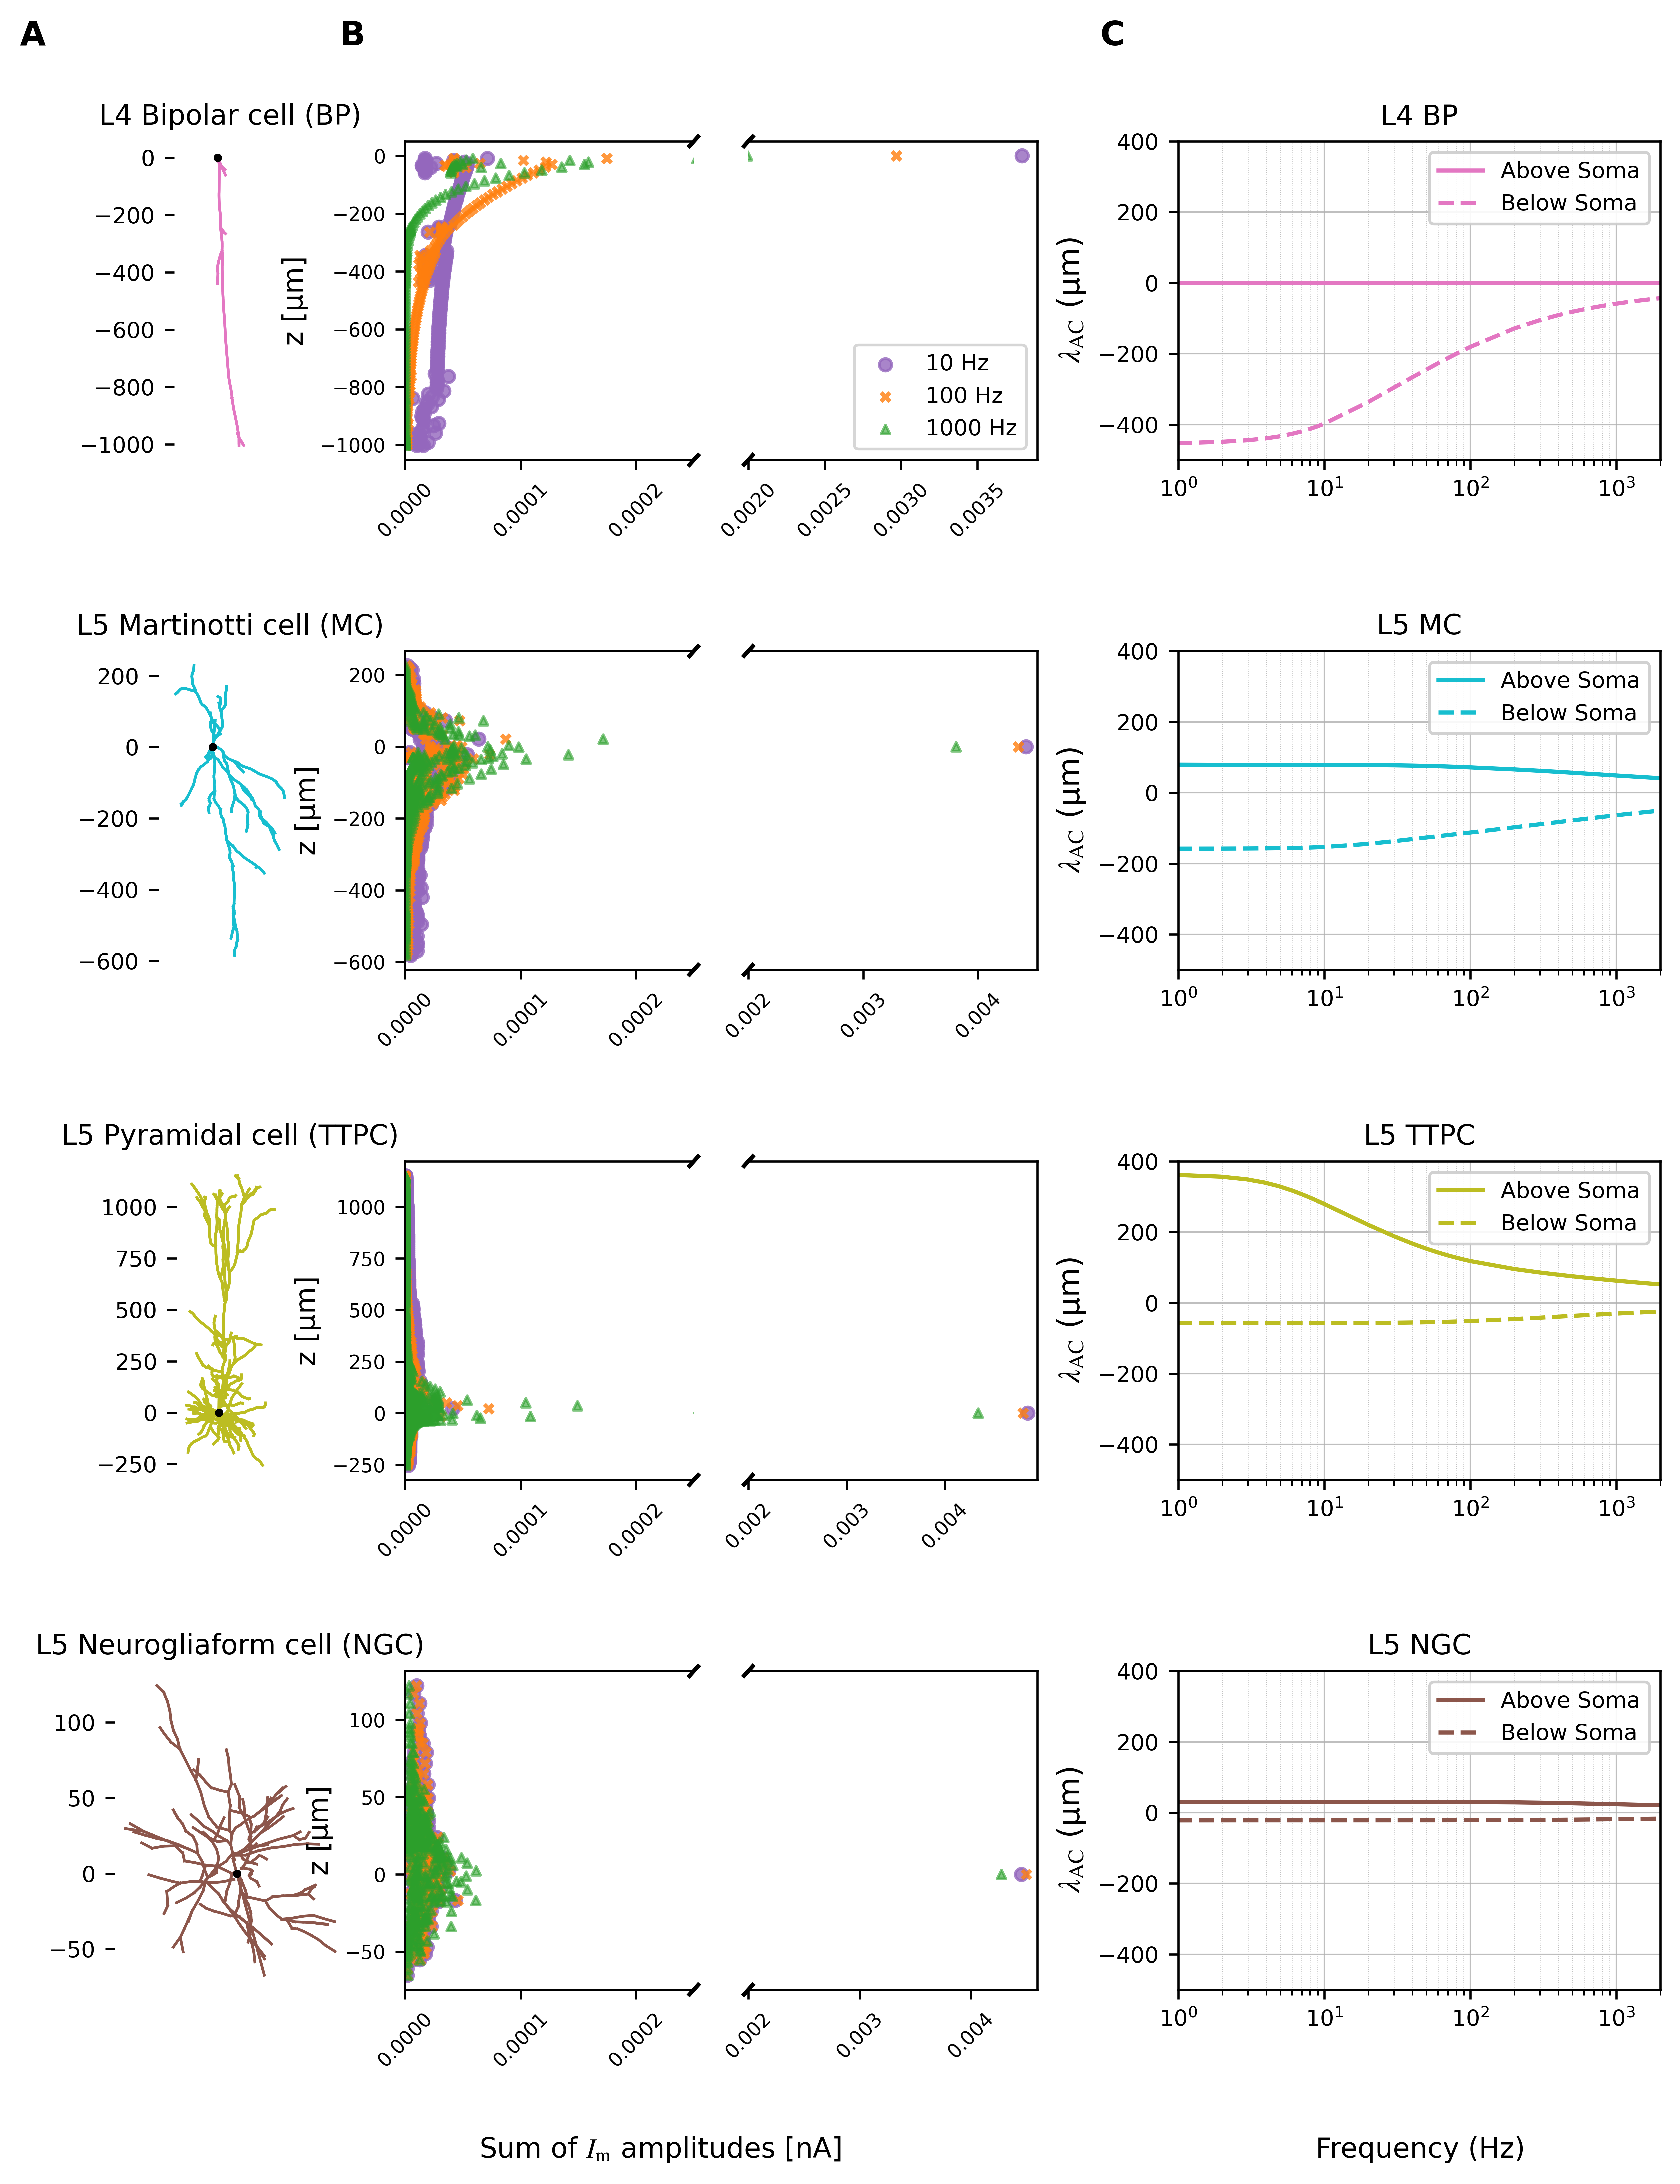

In [19]:
plot_imem_figure_neo(imem_plot_file_paths, subset_imem_data, selected_cells=selected_cells,xlim1=(0, 0.00025), xlim2=(0.002, None))